In [1]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [56]:
del(encoder)
del(decoder)
del(vae)

## Vanilla DAE

In [3]:
latent_dim=64
input_shape=(18,18,736)
batch_size=32

# def sampling(args):
#     z_mean, z_log_sigma = args
#     epsilon = K.random_normal(shape=((18,18,64)))
#     out = z_mean + K.exp(z_log_sigma) * epsilon
#     return out

# def vae_loss(x, x_decoded_mean):
#     xent_loss = binary_crossentropy(x, x_decoded_mean)
#     kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
#     return xent_loss + kl_loss

def add_noise(args):
    alpha = 0.5
    _input = args
    noise = K.random_normal(shape=(input_shape))
    _out = _input + (alpha*noise)
    _out = K.clip(_out, min_value=0., max_value=1.)
    return _out


x = Input(shape=(input_shape), name='input')

h = Lambda(add_noise, name='lambda_adding_noise')(x)

h = Dense(256, activation='relu', name='h')(h)

z = Dense(latent_dim, activation='relu', name='latent_layer')(h)

z = Dense(256, activation='relu', name='h_decoder')(z)
z = Dense(736, activation='sigmoid', name='output_decoder')(z)

# h_decoded = Dense(256, activation='relu', name='decoder_h')(z)

# h_decoded = Dense(736, activation='sigmoid', name='decoder_mean')(h_decoded)

vae = Model(x, z, name='vae')

encoder = Model(x, z, name='encoder')

decoder_input = Input(shape=(18,18,64))
# _h_decoded = Dense(256, activation='relu', name='decoder_h')(decoder_input)
# _x_decoded_mean = Dense(736, activation='sigmoid', name='decoder_mean')(_h_decoded)
decoder_output = Dense(256, activation='relu', name='h_decoder')(decoder_input)
decoder_output = Dense(736, activation='sigmoid', name='output_decoder')(decoder_output)

decoder = Model(decoder_input, decoder_output, name='decoder')

vae.compile(optimizer='rmsprop', loss=binary_crossentropy)

print('encoder')
encoder.summary()
print('decoder')
decoder.summary()
print('vae')
vae.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
encoder
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
lambda_adding_noise (Lambda) (None, 18, 18, 736)       0         
_________________________________________________________________
h (Dense)                    (None, 18, 18, 256)       188672    
_________________________________________________________________
latent_layer (Dense)         (None, 18, 18, 64)        16448     
_________________________________________________________________
h_decoder (Dense)            (None, 18, 18, 256)       16640     
_________________________________________________________________
output_d

In [62]:
def add_noise_demo(args):
    alpha = 0.5
    _input = args
    noise = K.random_normal(shape=(input_shape))
    _out = _input + (alpha*noise)
    _out = K.clip(_out, min_value=0., max_value=1.)
    return _out

input_shape = (399,399,3)
demo_input = Input(shape=input_shape)
demo_output = Lambda(add_noise_demo)(demo_input)

demo_model = Model(demo_input, demo_output)
demo_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 399, 399, 3)       0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 399, 399, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


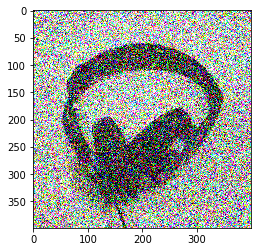

In [63]:
image = imread(os.path.join('/data/Quan/datasets/webcam/images/headphones',os.listdir('/data/Quan/datasets/webcam/images/headphones')[0]))
image = np.array(image, dtype='float64')
image /= 255.

image = np.expand_dims(image, axis=0)
pred_image = demo_model.predict(image)

plt.imshow(pred_image[0])

In [54]:
np.min(pred_image)

0.0

## D_VAE

In [10]:
latent_dim=64
input_shape=(18,18,736)
batch_size=32

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=((18,18,64)))
    out = z_mean + K.exp(z_log_sigma) * epsilon
    return out

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

def add_noise(args):
    alpha = 0.5
    _input = args
    noise = K.random_normal(shape=(input_shape))
    _out = _input + (alpha*noise)
    _out = K.clip(_out, min_value=0., max_value=1.)
    return _out


x = Input(shape=(input_shape), name='input')

h = Lambda(add_noise, name='lambda_adding_noise')(x)

h = Dense(256, activation='relu', name='h')(h)

z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_sigma = Dense(latent_dim, name='z_log_sigma')(h)

z = Lambda(sampling, name='lambda_sampling')([z_mean,z_log_sigma])

h_decoded = Dense(256, activation='relu', name='decoder_h')(z)
x_decoded_mean = Dense(736, activation='sigmoid', name='decoder_mean')(h_decoded)

vae = Model(x, x_decoded_mean, name='vae')

encoder = Model(x, z, name='encoder')

decoder_input = Input(shape=(18,18,64))
_h_decoded = Dense(256, activation='relu', name='decoder_h')(decoder_input)
_x_decoded_mean = Dense(736, activation='sigmoid', name='decoder_mean')(_h_decoded)

decoder = Model(decoder_input, _x_decoded_mean, name='decoder')

vae.compile(optimizer='rmsprop', loss=vae_loss)

print('encoder')
encoder.summary()
print('decoder')
decoder.summary()
print('vae')
vae.summary()


encoder
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
lambda_adding_noise (Lambda)    (None, 18, 18, 736)  0           input[0][0]                      
__________________________________________________________________________________________________
h (Dense)                       (None, 18, 18, 256)  188672      lambda_adding_noise[0][0]        
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
z_

## VAE

In [4]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=((18,18,64)))
    out = z_mean + K.exp(z_log_sigma) * epsilon
    return out

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss



latent_dim=64
input_shape=(18,18,736)
batch_size=32

x = Input(shape=(input_shape), name='input')

h = Dense(256, activation='relu', name='h')(x)

z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_sigma = Dense(latent_dim, name='z_log_sigma')(h)

z = Lambda(sampling, name='lambda_sampling')([z_mean,z_log_sigma])

h_decoded = Dense(256, activation='relu', name='decoder_h')(z)
x_decoded_mean = Dense(736, activation='sigmoid', name='decoder_mean')(h_decoded)

vae = Model(x, x_decoded_mean, name='vae')

encoder = Model(x, z, name='encoder')

decoder_input = Input(shape=(18,18,64))
_h_decoded = Dense(256, activation='relu', name='decoder_h')(decoder_input)
_x_decoded_mean = Dense(736, activation='sigmoid', name='decoder_mean')(_h_decoded)

decoder = Model(decoder_input, _x_decoded_mean, name='decoder')

vae.compile(optimizer='rmsprop', loss=vae_loss)

print('encoder')
encoder.summary()
print('decoder')
decoder.summary()
print('vae')
vae.summary()


encoder
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
h (Dense)                       (None, 18, 18, 256)  188672      input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
la

In [6]:
vae_loss

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [52]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/tf/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

label_dict = test_generator.class_indices

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.


In [53]:
with open('/tf/data/Quan/tf_models/amazon/extracted_features.hdf5', 'rb') as dt:
    s_labels, s_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'rb') as dt:
    sval_labels, sval_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
    t_labels, t_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'rb') as dt:
    tval_labels, tval_features = pickle.load(dt)

with open('/tf/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    ttest_labels, ttest_features = pickle.load(dt)

# s_labels = [k.split('/')[-2] for k in s_labels]
# sval_labels = [k.split('/')[-2] for k in sval_labels]

t_labels = [k.split('/')[-2] for k in t_labels]
tval_labels = [k.split('/')[-2] for k in tval_labels]
    
# s_features.shape, sval_features.shape, t_features.shape

## Amazon

In [54]:
batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/amazon/vanilla_dae_p36_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(s_features, s_features, batch_size=batch_size, epochs=50, 
          validation_data=(sval_features, sval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/amazon/vanilla_dae_p36_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 1576 samples, validate on 395 samples
Epoch 1/50
1576/1576 [==============================] - 2s 1ms/step - loss: -138.4563 - val_loss: -777.0332
Epoch 2/50
1576/1576 [==============================] - 2s 1ms/step - loss: -2816.3932 - val_loss: -7325.2099
Epoch 3/50
1576/1576 [==============================] - 2s 1ms/step - loss: -13492.7552 - val_loss: -26747.1079
Epoch 4/50
1576/1576 [==============================] - 2s 1ms/step - loss: -40986.7376 - val_loss: -70752.6104
Epoch 5/50
1576/1576 [==============================] - 2s 1ms/step - loss: -94196.1253 - val_loss: -151134.8562
Epoch 6/50
1576/1576 [==============================] - 2s 993us/step - loss: -186219.7603 - val_loss: -283220.4919
Epoch 7/50
1576/1576 [==============================] - 2s 1ms/step - loss: -333893.8674 - val_loss: -486073.1558
Epoch 8/50
1576/1576 [==============================] - 2s 1ms/step - loss: -547266.3230 - val_loss: -779687.9571
Epoch 9/50
1576/1576 [==============================] 

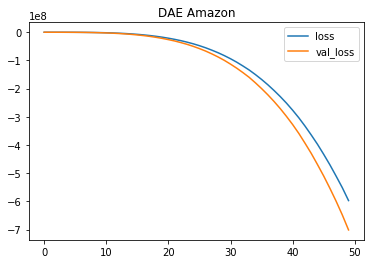

In [55]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('DAE Amazon')
plt.show()

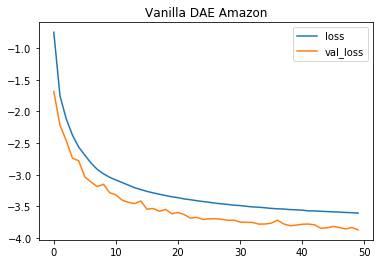

In [7]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Vanilla DAE Amazon')
plt.show()

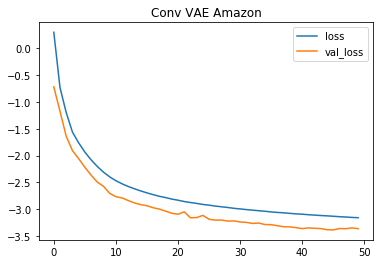

In [79]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Amazon')
plt.show()

## Webcam

In [58]:
batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam/vanilla_dae_p36_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(t_features, t_features, batch_size=batch_size, epochs=100, 
          validation_data=(tval_features, tval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam/vanilla_dae_p36_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 2ms/step - loss: 0.6022 - val_loss: 0.4769
Epoch 2/100
444/444 [==============================] - 1s 1ms/step - loss: 0.3595 - val_loss: 0.0321
Epoch 3/100
444/444 [==============================] - 1s 1ms/step - loss: -0.3073 - val_loss: -1.3076
Epoch 4/100
444/444 [==============================] - 0s 1ms/step - loss: -2.1295 - val_loss: -4.7960
Epoch 5/100
444/444 [==============================] - 1s 1ms/step - loss: -7.8812 - val_loss: -15.6256
Epoch 6/100
444/444 [==============================] - 1s 1ms/step - loss: -21.7954 - val_loss: -38.9357
Epoch 7/100
444/444 [==============================] - 0s 1ms/step - loss: -51.7691 - val_loss: -85.5897
Epoch 8/100
444/444 [==============================] - 0s 1ms/step - loss: -109.2079 - val_loss: -167.1371
Epoch 9/100
444/444 [==============================] - 0s 989us/step - loss: -205.2553 - val_loss: -304.3237
Epoch 10/100
444

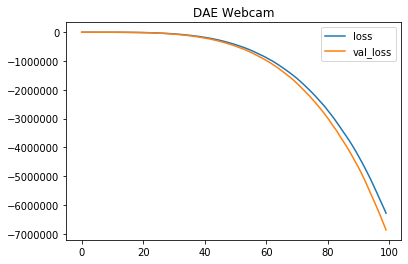

In [59]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('DAE Webcam')
plt.show()

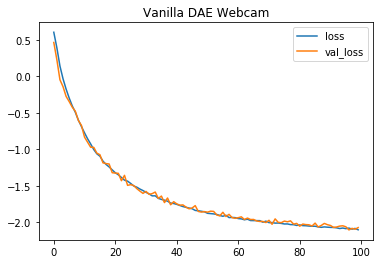

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Vanilla DAE Webcam')
plt.show()

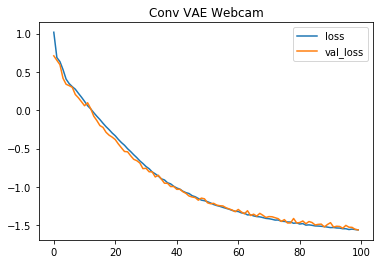

In [83]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Webcam')
plt.show()

## Combine

In [60]:
import keras.losses
# keras.losses.vae_loss = vae_loss
input_shape = (18,18,736)

s_vae = load_model('/tf/data/Quan/tf_models/amazon/vanilla_dae_p36_model.hdf5', custom_objects={'input_shape': input_shape})
t_vae = load_model('/tf/data/Quan/tf_models/webcam/vanilla_dae_p36_model.hdf5', custom_objects={'input_shape': input_shape})

s_vae.summary()
t_vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
lambda_adding_noise (Lambda) (None, 18, 18, 736)       0         
_________________________________________________________________
h (Dense)                    (None, 18, 18, 256)       188672    
_________________________________________________________________
latent_layer (Dense)         (None, 18, 18, 64)        16448     
_________________________________________________________________
h_decoder (Dense)            (None, 18, 18, 256)       16640     
_________________________________________________________________
output_decoder (Dense)       (None, 18, 18, 736)       189152    
Total params: 410,912
Trainable params: 410,912
Non-trainable params: 0
_________________________________________________________

In [63]:
import keras.losses
# keras.losses.vae_loss = vae_loss

# t encoder
t_encoder = Model(t_vae.inputs, t_vae.layers[3].output)

# s decoder
decoder_input = Input(shape=(18,18,64))
_h_decoded = Dense(256, activation='relu', name='decoder_h')(decoder_input)
_x_decoded_mean = Dense(736, activation='sigmoid', name='decoder_mean')(_h_decoded)

s_decoder = Model(decoder_input, _x_decoded_mean, name='decoder')

for i in range(-2,0):
    s_decoder.layers[i].set_weights(s_vae.layers[i].get_weights())
    
print('t_encoder')
t_encoder.summary()

print('s_decoder')
s_decoder.summary()

t_encoder
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
lambda_adding_noise (Lambda) (None, 18, 18, 736)       0         
_________________________________________________________________
h (Dense)                    (None, 18, 18, 256)       188672    
_________________________________________________________________
latent_layer (Dense)         (None, 18, 18, 64)        16448     
Total params: 205,120
Trainable params: 205,120
Non-trainable params: 0
_________________________________________________________________
s_decoder
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 18, 18, 64)        0         
________________

In [64]:
c_dae_outputs = s_decoder(t_encoder(t_encoder.inputs))
c_dae = Model(t_encoder.inputs, c_dae_outputs, name='combined_vae')
c_dae.summary()

Model: "combined_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
model_5 (Model)              (None, 18, 18, 64)        205120    
_________________________________________________________________
decoder (Model)              (None, 18, 18, 736)       205792    
Total params: 410,912
Trainable params: 410,912
Non-trainable params: 0
_________________________________________________________________


In [65]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_dae.predict(t_features, verbose=1)
val_transform_features = c_dae.predict(tval_features, verbose=1)
test_transform_features = c_dae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 856us/step


In [18]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.05), metrics=['accuracy'])
s_topmodel.summary()

W1215 10:07:17.087995 140145451017984 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W1215 10:07:17.194668 140145451017984 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1215 10:07:17.875258 140145451017984 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 736)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 31)                22847     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31)                124       
_________________________________________________________________
activation_1 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_________________________________________________________________


In [17]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 3ms/step


[3.8863200782233203, 0.02092050209205021]

In [19]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_dvae_classifier_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=300,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_dvae_classifier_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/300
444/444 [==============================] - 1s 2ms/step - loss: 2.0501 - acc: 0.4707 - val_loss: 1.5635 - val_acc: 0.5714
Epoch 2/300
444/444 [==============================] - 0s 681us/step - loss: 1.1080 - acc: 0.7230 - val_loss: 1.1742 - val_acc: 0.6875
Epoch 3/300
444/444 [==============================] - 0s 676us/step - loss: 0.8229 - acc: 0.7950 - val_loss: 1.0054 - val_acc: 0.7321
Epoch 4/300
444/444 [==============================] - 0s 680us/step - loss: 0.7881 - acc: 0.7860 - val_loss: 0.9479 - val_acc: 0.7054
Epoch 5/300
444/444 [==============================] - 0s 684us/step - loss: 0.6350 - acc: 0.8581 - val_loss: 0.8587 - val_acc: 0.7411
Epoch 6/300
444/444 [==============================] - 0s 681us/step - loss: 0.6130 - acc: 0.8333 - val_loss: 0.8332 - val_acc: 0.7232
Epoch 7/300
444/444 [==============================] - 0s 679us/step - loss: 0.5637 - acc: 0.8401 - val_loss: 0.7992 - val_acc: 0.7411
Epoch 8/300

Epoch 61/300
444/444 [==============================] - 0s 685us/step - loss: 0.2337 - acc: 0.9369 - val_loss: 0.5110 - val_acc: 0.8571
Epoch 62/300
444/444 [==============================] - 0s 683us/step - loss: 0.2557 - acc: 0.9324 - val_loss: 0.5122 - val_acc: 0.8750
Epoch 63/300
444/444 [==============================] - 0s 681us/step - loss: 0.2569 - acc: 0.8964 - val_loss: 0.5493 - val_acc: 0.8482
Epoch 64/300
444/444 [==============================] - 0s 683us/step - loss: 0.2466 - acc: 0.9054 - val_loss: 0.5695 - val_acc: 0.8571
Epoch 65/300
444/444 [==============================] - 0s 680us/step - loss: 0.2465 - acc: 0.9099 - val_loss: 0.5492 - val_acc: 0.8571
Epoch 66/300
444/444 [==============================] - 0s 681us/step - loss: 0.1734 - acc: 0.9414 - val_loss: 0.5159 - val_acc: 0.8661
Epoch 67/300
444/444 [==============================] - 0s 680us/step - loss: 0.1809 - acc: 0.9572 - val_loss: 0.5215 - val_acc: 0.8661
Epoch 68/300
444/444 [==========================

444/444 [==============================] - 0s 699us/step - loss: 0.1783 - acc: 0.9482 - val_loss: 0.4875 - val_acc: 0.8393
Epoch 122/300
444/444 [==============================] - 0s 692us/step - loss: 0.1681 - acc: 0.9437 - val_loss: 0.4781 - val_acc: 0.8571
Epoch 123/300
444/444 [==============================] - 0s 681us/step - loss: 0.1808 - acc: 0.9324 - val_loss: 0.4762 - val_acc: 0.8393
Epoch 124/300
444/444 [==============================] - 0s 680us/step - loss: 0.1604 - acc: 0.9437 - val_loss: 0.4651 - val_acc: 0.8571
Epoch 125/300
444/444 [==============================] - 0s 679us/step - loss: 0.1749 - acc: 0.9482 - val_loss: 0.4914 - val_acc: 0.8661
Epoch 126/300
444/444 [==============================] - 0s 683us/step - loss: 0.1515 - acc: 0.9437 - val_loss: 0.5005 - val_acc: 0.8482
Epoch 127/300
444/444 [==============================] - 0s 683us/step - loss: 0.1623 - acc: 0.9482 - val_loss: 0.4868 - val_acc: 0.8482
Epoch 128/300
444/444 [==============================] 

Epoch 181/300
444/444 [==============================] - 0s 683us/step - loss: 0.1447 - acc: 0.9527 - val_loss: 0.5575 - val_acc: 0.8304
Epoch 182/300
444/444 [==============================] - 0s 679us/step - loss: 0.1791 - acc: 0.9234 - val_loss: 0.5100 - val_acc: 0.8393
Epoch 183/300
444/444 [==============================] - 0s 681us/step - loss: 0.1205 - acc: 0.9550 - val_loss: 0.4920 - val_acc: 0.8482
Epoch 184/300
444/444 [==============================] - 0s 682us/step - loss: 0.1274 - acc: 0.9617 - val_loss: 0.4544 - val_acc: 0.8661
Epoch 185/300
444/444 [==============================] - 0s 680us/step - loss: 0.1600 - acc: 0.9572 - val_loss: 0.4473 - val_acc: 0.8839
Epoch 186/300
444/444 [==============================] - 0s 682us/step - loss: 0.1180 - acc: 0.9640 - val_loss: 0.4440 - val_acc: 0.8661
Epoch 187/300
444/444 [==============================] - 0s 682us/step - loss: 0.1220 - acc: 0.9685 - val_loss: 0.4231 - val_acc: 0.8750
Epoch 188/300
444/444 [==================

Epoch 241/300
444/444 [==============================] - 0s 674us/step - loss: 0.1276 - acc: 0.9550 - val_loss: 0.5200 - val_acc: 0.8482
Epoch 242/300
444/444 [==============================] - 0s 678us/step - loss: 0.1545 - acc: 0.9392 - val_loss: 0.5085 - val_acc: 0.8571
Epoch 243/300
444/444 [==============================] - 0s 683us/step - loss: 0.1785 - acc: 0.9414 - val_loss: 0.4973 - val_acc: 0.8482
Epoch 244/300
444/444 [==============================] - 0s 682us/step - loss: 0.1352 - acc: 0.9437 - val_loss: 0.4908 - val_acc: 0.8571
Epoch 245/300
444/444 [==============================] - 0s 681us/step - loss: 0.1440 - acc: 0.9550 - val_loss: 0.4958 - val_acc: 0.8661
Epoch 246/300
444/444 [==============================] - 0s 680us/step - loss: 0.0894 - acc: 0.9707 - val_loss: 0.5105 - val_acc: 0.8661
Epoch 247/300
444/444 [==============================] - 0s 681us/step - loss: 0.1668 - acc: 0.9550 - val_loss: 0.5003 - val_acc: 0.8482
Epoch 248/300
444/444 [==================

exe time:  92.4381103515625


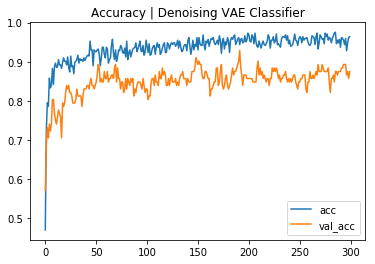

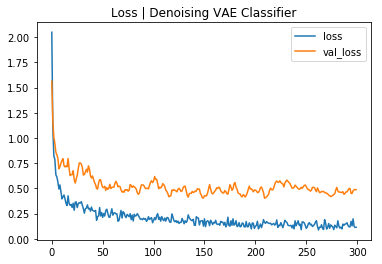

In [20]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.title('Accuracy | Denoising VAE Classifier')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss | Denoising VAE Classifier')
plt.show()

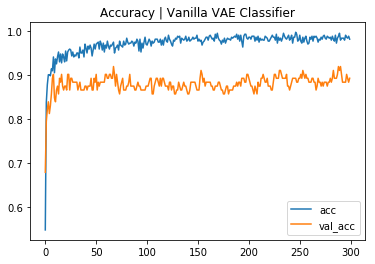

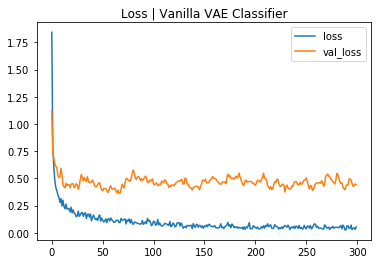

In [23]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.title('Accuracy | Vanilla VAE Classifier')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss | Vanilla VAE Classifier')
plt.show()

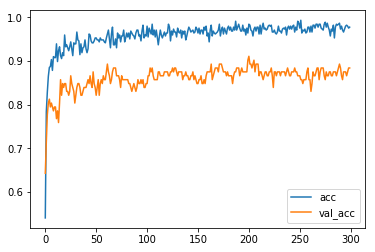

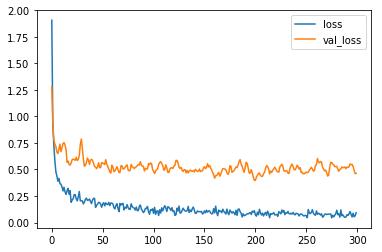

In [107]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [21]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_dvae_classifier_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 0s 2ms/step


[0.744591687014911, 0.7866108801574387]

In [24]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_dae_classifier_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 0s 1ms/step


[0.5796928537939383, 0.8451882860151794]

### Training classifier from scratch

In [66]:
# retrain source classifier

# Get source classififer (amazon)

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.05), metrics=['accuracy'])


In [67]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_dae_classifier_scratch_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=300,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_dae_classifier_scratch_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/300
444/444 [==============================] - 0s 1ms/step - loss: 3.6824 - accuracy: 0.0495 - val_loss: 9.8934 - val_accuracy: 0.0446
Epoch 2/300
444/444 [==============================] - 0s 392us/step - loss: 3.4345 - accuracy: 0.0743 - val_loss: 6.6465 - val_accuracy: 0.0268
Epoch 3/300
 32/444 [=>............................] - ETA: 0s - loss: 3.4278 - accuracy: 0.0000e+00

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


444/444 [==============================] - 0s 418us/step - loss: 3.4032 - accuracy: 0.0518 - val_loss: 5.6219 - val_accuracy: 0.0268
Epoch 4/300
444/444 [==============================] - 0s 487us/step - loss: 3.3712 - accuracy: 0.0608 - val_loss: 4.2005 - val_accuracy: 0.0268
Epoch 5/300
444/444 [==============================] - 0s 445us/step - loss: 3.3555 - accuracy: 0.0676 - val_loss: 4.0388 - val_accuracy: 0.0536
Epoch 6/300
444/444 [==============================] - 0s 418us/step - loss: 3.3273 - accuracy: 0.0901 - val_loss: 3.9010 - val_accuracy: 0.0446
Epoch 7/300
444/444 [==============================] - 0s 415us/step - loss: 3.3488 - accuracy: 0.0608 - val_loss: 3.6717 - val_accuracy: 0.0714
Epoch 8/300
444/444 [==============================] - 0s 415us/step - loss: 3.3329 - accuracy: 0.0698 - val_loss: 3.6303 - val_accuracy: 0.0536
Epoch 9/300
444/444 [==============================] - 0s 415us/step - loss: 3.3070 - accuracy: 0.0811 - val_loss: 3.4604 - val_accuracy: 0.09

444/444 [==============================] - 0s 395us/step - loss: 2.9846 - accuracy: 0.1329 - val_loss: 2.9505 - val_accuracy: 0.1250
Epoch 116/300
444/444 [==============================] - 0s 464us/step - loss: 3.0582 - accuracy: 0.0923 - val_loss: 2.9697 - val_accuracy: 0.1250
Epoch 117/300
444/444 [==============================] - 0s 541us/step - loss: 2.9976 - accuracy: 0.1171 - val_loss: 2.9932 - val_accuracy: 0.1071
Epoch 118/300
444/444 [==============================] - 0s 533us/step - loss: 2.9726 - accuracy: 0.1374 - val_loss: 2.9638 - val_accuracy: 0.1071
Epoch 119/300
444/444 [==============================] - 0s 425us/step - loss: 3.0566 - accuracy: 0.1014 - val_loss: 2.9611 - val_accuracy: 0.1429
Epoch 120/300
444/444 [==============================] - 0s 413us/step - loss: 2.9649 - accuracy: 0.1306 - val_loss: 2.9708 - val_accuracy: 0.1607
Epoch 121/300
444/444 [==============================] - 0s 477us/step - loss: 3.0180 - accuracy: 0.1171 - val_loss: 2.9731 - val_ac

Epoch 171/300
444/444 [==============================] - 0s 409us/step - loss: 2.9579 - accuracy: 0.1239 - val_loss: 2.9948 - val_accuracy: 0.1071
Epoch 172/300
444/444 [==============================] - 0s 411us/step - loss: 3.0364 - accuracy: 0.1194 - val_loss: 2.9517 - val_accuracy: 0.1250
Epoch 173/300
444/444 [==============================] - 0s 424us/step - loss: 2.9932 - accuracy: 0.1419 - val_loss: 2.9666 - val_accuracy: 0.1429
Epoch 174/300
444/444 [==============================] - 0s 419us/step - loss: 2.9766 - accuracy: 0.1149 - val_loss: 2.9634 - val_accuracy: 0.1250
Epoch 175/300
444/444 [==============================] - 0s 403us/step - loss: 2.9490 - accuracy: 0.1284 - val_loss: 2.9580 - val_accuracy: 0.1518
Epoch 176/300
444/444 [==============================] - 0s 398us/step - loss: 2.9696 - accuracy: 0.1216 - val_loss: 2.9540 - val_accuracy: 0.1339
Epoch 177/300
444/444 [==============================] - 0s 403us/step - loss: 2.9751 - accuracy: 0.1171 - val_loss: 2

Epoch 227/300
444/444 [==============================] - 0s 470us/step - loss: 2.9581 - accuracy: 0.1329 - val_loss: 2.8578 - val_accuracy: 0.1786
Epoch 228/300
444/444 [==============================] - 0s 453us/step - loss: 2.9797 - accuracy: 0.1104 - val_loss: 2.8622 - val_accuracy: 0.1607
Epoch 229/300
444/444 [==============================] - 0s 423us/step - loss: 2.9257 - accuracy: 0.1329 - val_loss: 2.8635 - val_accuracy: 0.1786
Epoch 230/300
444/444 [==============================] - 0s 397us/step - loss: 2.9780 - accuracy: 0.1306 - val_loss: 2.8510 - val_accuracy: 0.1696
Epoch 231/300
444/444 [==============================] - 0s 414us/step - loss: 2.9447 - accuracy: 0.1441 - val_loss: 2.8825 - val_accuracy: 0.1607
Epoch 232/300
444/444 [==============================] - 0s 391us/step - loss: 2.9694 - accuracy: 0.1374 - val_loss: 2.8939 - val_accuracy: 0.1518
Epoch 233/300
444/444 [==============================] - 0s 392us/step - loss: 2.9734 - accuracy: 0.1306 - val_loss: 2

Epoch 283/300
444/444 [==============================] - 0s 388us/step - loss: 2.9383 - accuracy: 0.1329 - val_loss: 2.8456 - val_accuracy: 0.1250
Epoch 284/300
444/444 [==============================] - 0s 409us/step - loss: 2.9151 - accuracy: 0.1239 - val_loss: 2.8112 - val_accuracy: 0.1518
Epoch 285/300
444/444 [==============================] - 0s 407us/step - loss: 2.9847 - accuracy: 0.1216 - val_loss: 2.8206 - val_accuracy: 0.1250
Epoch 286/300
444/444 [==============================] - 0s 373us/step - loss: 2.9397 - accuracy: 0.1239 - val_loss: 2.8300 - val_accuracy: 0.1518
Epoch 287/300
444/444 [==============================] - 0s 385us/step - loss: 2.9311 - accuracy: 0.1419 - val_loss: 2.8483 - val_accuracy: 0.1518
Epoch 288/300
444/444 [==============================] - 0s 413us/step - loss: 2.9150 - accuracy: 0.1509 - val_loss: 2.8873 - val_accuracy: 0.1161
Epoch 289/300
444/444 [==============================] - 0s 500us/step - loss: 2.9160 - accuracy: 0.1306 - val_loss: 2

FileNotFoundError: [Errno 2] No such file or directory: '/data/Quan/tf_models/webcam/amazon_dae_classifier_scratch_history.hdf5'

## Combine VAE

In [87]:
import keras.losses
keras.losses.vae_loss = vae_loss

s_vae = load_model('/data/Quan/tf_models/amazon/vae2_model.hdf5')
t_vae = load_model('/data/Quan/tf_models/webcam/vae2_model.hdf5')

s_vae.summary()
t_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
h (Dense)                       (None, 18, 18, 256)  188672      input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
lambda_sam

In [88]:
import keras.losses
keras.losses.vae_loss = vae_loss

# t encoder
t_encoder = Model(t_vae.inputs, t_vae.layers[4].output)

# s decoder
decoder_input = Input(shape=(18,18,64))
_h_decoded = Dense(256, activation='relu', name='decoder_h')(decoder_input)
_x_decoded_mean = Dense(736, activation='sigmoid', name='decoder_mean')(_h_decoded)

s_decoder = Model(decoder_input, _x_decoded_mean, name='decoder')

for i in range(-2,0):
    s_decoder.layers[i].set_weights(s_vae.layers[i].get_weights())
    
print('t_encoder')
t_encoder.summary()

print('s_decoder')
s_decoder.summary()

t_encoder
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
h (Dense)                       (None, 18, 18, 256)  188672      input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________


In [89]:
c_vae_outputs = s_decoder(t_encoder(t_encoder.inputs))
c_vae = Model(t_encoder.inputs, c_vae_outputs, name='combined_vae')
c_vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
model_11 (Model)             (None, 18, 18, 64)        221568    
_________________________________________________________________
decoder (Model)              (None, 18, 18, 736)       205792    
Total params: 427,360
Trainable params: 427,360
Non-trainable params: 0
_________________________________________________________________


In [90]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_vae.predict(t_features, verbose=1)
val_transform_features = c_vae.predict(tval_features, verbose=1)
test_transform_features = c_vae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 1ms/step


In [103]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.05), metrics=['accuracy'])
s_topmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_10  (None, 736)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 736)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 31)                22847     
_________________________________________________________________
batch_normalization_10 (Batc (None, 31)                124       
_________________________________________________________________
activation_25 (Activation)   (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_________________________________________________________________


In [17]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 3ms/step


[3.8863200782233203, 0.02092050209205021]

In [104]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=300,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_classifier2_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/300
444/444 [==============================] - 6s 14ms/step - loss: 1.9063 - acc: 0.5405 - val_loss: 1.2786 - val_acc: 0.6429
Epoch 2/300
444/444 [==============================] - 0s 561us/step - loss: 0.9301 - acc: 0.7838 - val_loss: 0.9351 - val_acc: 0.7143
Epoch 3/300
444/444 [==============================] - 0s 557us/step - loss: 0.7312 - acc: 0.8288 - val_loss: 0.7812 - val_acc: 0.7768
Epoch 4/300
444/444 [==============================] - 0s 556us/step - loss: 0.5851 - acc: 0.8649 - val_loss: 0.7397 - val_acc: 0.8036
Epoch 5/300
444/444 [==============================] - 0s 555us/step - loss: 0.4781 - acc: 0.8851 - val_loss: 0.7184 - val_acc: 0.8125
Epoch 6/300
444/444 [==============================] - 0s 556us/step - loss: 0.4391 - acc: 0.8874 - val_loss: 0.6635 - val_acc: 0.7946
Epoch 7/300
444/444 [==============================] - 0s 556us/step - loss: 0.3895 - acc: 0.9032 - val_loss: 0.6499 - val_acc: 0.8036
Epoch 8/30

Epoch 61/300
444/444 [==============================] - 0s 558us/step - loss: 0.1766 - acc: 0.9527 - val_loss: 0.5233 - val_acc: 0.8750
Epoch 62/300
444/444 [==============================] - 0s 555us/step - loss: 0.1410 - acc: 0.9617 - val_loss: 0.4802 - val_acc: 0.8929
Epoch 63/300
444/444 [==============================] - 0s 552us/step - loss: 0.1280 - acc: 0.9707 - val_loss: 0.4864 - val_acc: 0.8750
Epoch 64/300
444/444 [==============================] - 0s 553us/step - loss: 0.1610 - acc: 0.9505 - val_loss: 0.5055 - val_acc: 0.8661
Epoch 65/300
444/444 [==============================] - 0s 553us/step - loss: 0.1777 - acc: 0.9302 - val_loss: 0.5272 - val_acc: 0.8482
Epoch 66/300
444/444 [==============================] - 0s 554us/step - loss: 0.1342 - acc: 0.9617 - val_loss: 0.4998 - val_acc: 0.8571
Epoch 67/300
444/444 [==============================] - 0s 553us/step - loss: 0.1025 - acc: 0.9775 - val_loss: 0.4715 - val_acc: 0.8750
Epoch 68/300
444/444 [==========================

444/444 [==============================] - 0s 553us/step - loss: 0.1098 - acc: 0.9640 - val_loss: 0.5319 - val_acc: 0.8750
Epoch 122/300
444/444 [==============================] - 0s 567us/step - loss: 0.0673 - acc: 0.9842 - val_loss: 0.5402 - val_acc: 0.8661
Epoch 123/300
444/444 [==============================] - 0s 562us/step - loss: 0.0733 - acc: 0.9775 - val_loss: 0.5856 - val_acc: 0.8661
Epoch 124/300
444/444 [==============================] - 0s 558us/step - loss: 0.1355 - acc: 0.9459 - val_loss: 0.5853 - val_acc: 0.8750
Epoch 125/300
444/444 [==============================] - 0s 558us/step - loss: 0.1083 - acc: 0.9685 - val_loss: 0.5622 - val_acc: 0.8750
Epoch 126/300
444/444 [==============================] - 0s 553us/step - loss: 0.1552 - acc: 0.9595 - val_loss: 0.5196 - val_acc: 0.8839
Epoch 127/300
444/444 [==============================] - 0s 555us/step - loss: 0.0894 - acc: 0.9730 - val_loss: 0.5106 - val_acc: 0.8750
Epoch 128/300
444/444 [==============================] 

Epoch 181/300
444/444 [==============================] - 0s 551us/step - loss: 0.0736 - acc: 0.9797 - val_loss: 0.5052 - val_acc: 0.8661
Epoch 182/300
444/444 [==============================] - 0s 555us/step - loss: 0.1164 - acc: 0.9707 - val_loss: 0.5247 - val_acc: 0.8661
Epoch 183/300
444/444 [==============================] - 0s 553us/step - loss: 0.0664 - acc: 0.9775 - val_loss: 0.5173 - val_acc: 0.8661
Epoch 184/300
444/444 [==============================] - 0s 557us/step - loss: 0.1249 - acc: 0.9685 - val_loss: 0.5426 - val_acc: 0.8661
Epoch 185/300
444/444 [==============================] - 0s 557us/step - loss: 0.1276 - acc: 0.9685 - val_loss: 0.5734 - val_acc: 0.8482
Epoch 186/300
444/444 [==============================] - 0s 556us/step - loss: 0.1024 - acc: 0.9775 - val_loss: 0.5936 - val_acc: 0.8661
Epoch 187/300
444/444 [==============================] - 0s 555us/step - loss: 0.0869 - acc: 0.9707 - val_loss: 0.5482 - val_acc: 0.8750
Epoch 188/300
444/444 [==================

Epoch 241/300
444/444 [==============================] - 0s 557us/step - loss: 0.0879 - acc: 0.9730 - val_loss: 0.5125 - val_acc: 0.8661
Epoch 242/300
444/444 [==============================] - 0s 556us/step - loss: 0.0840 - acc: 0.9797 - val_loss: 0.5405 - val_acc: 0.8661
Epoch 243/300
444/444 [==============================] - 0s 552us/step - loss: 0.0802 - acc: 0.9730 - val_loss: 0.5258 - val_acc: 0.8750
Epoch 244/300
444/444 [==============================] - 0s 552us/step - loss: 0.0616 - acc: 0.9797 - val_loss: 0.5037 - val_acc: 0.8750
Epoch 245/300
444/444 [==============================] - 0s 551us/step - loss: 0.0778 - acc: 0.9820 - val_loss: 0.5170 - val_acc: 0.8750
Epoch 246/300
444/444 [==============================] - 0s 552us/step - loss: 0.0807 - acc: 0.9662 - val_loss: 0.4712 - val_acc: 0.8839
Epoch 247/300
444/444 [==============================] - 0s 559us/step - loss: 0.0759 - acc: 0.9775 - val_loss: 0.4731 - val_acc: 0.8750
Epoch 248/300
444/444 [==================

exe time:  84.73720645904541


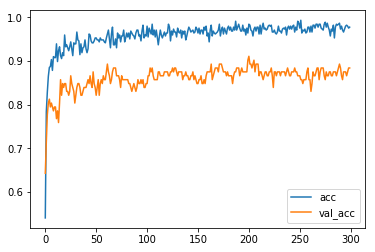

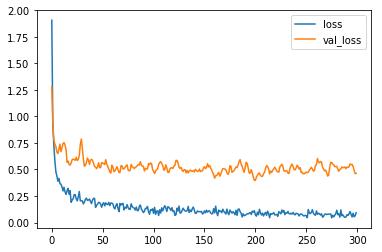

In [107]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [109]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 2s 10ms/step


[0.7559444258402581, 0.8368200844301839]

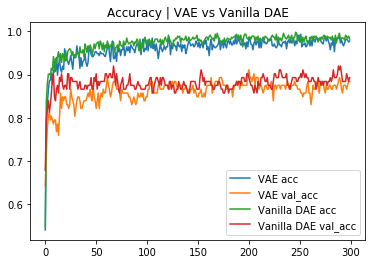

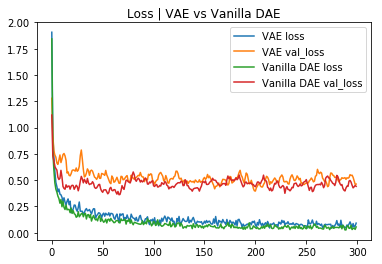

In [26]:
with open('/data/Quan/tf_models/webcam/amazon_classifier2_history.hdf5', 'rb') as dt:
    vae_history = pickle.load(dt)

    
%matplotlib inline
plt.plot(vae_history.history['acc'], label='VAE acc')
plt.plot(vae_history.history['val_acc'], label='VAE val_acc')
plt.plot(history.history['acc'], label='Vanilla DAE acc')
plt.plot(history.history['val_acc'], label='Vanilla DAE val_acc')
plt.legend()
plt.title('Accuracy | VAE vs Vanilla DAE')
plt.show()

plt.plot(vae_history.history['loss'], label='VAE loss')
plt.plot(vae_history.history['val_loss'], label='VAE val_loss')
plt.plot(history.history['loss'], label='Vanilla DAE loss')
plt.plot(history.history['val_loss'], label='Vanilla DAE val_loss')
plt.legend()
plt.title('Loss | VAE vs Vanilla DAE')
plt.show()